W0608 10:37:52.802253   274 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0608 10:37:52.803737   274 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


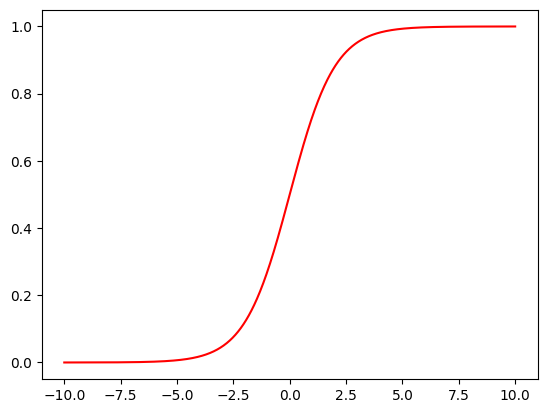

In [1]:
import paddle
from matplotlib import pyplot as plt

def logistic(x):
    return 1/(1+paddle.exp(-x)) 

x = paddle.linspace(-10, 10, 1000)
plt.figure() 
plt.plot(x.tolist(), logistic(x).tolist(), color="red", label="Logistic Function")

In [6]:
import math
import copy

def make_moons(n_samples=1000, shuffle=True, noise=None):
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out 
    outer_circ_x = paddle.cos(paddle.linspace(0, math.pi, n_samples_out))
    outer_circ_y = paddle.sin(paddle.linspace(0, math.pi, n_samples_out))
    inner_circ_x = 1 - paddle.cos(paddle.linspace(0, math.pi, n_samples_in))
    inner_circ_y = 0.5 - paddle.sin(paddle.linspace(0, math.pi, n_samples_in))
    X = paddle.stack([paddle.concat([outer_circ_x, inner_circ_x]), paddle.concat([outer_circ_y, inner_circ_y])], axis=1) 
    y = paddle.concat([paddle.zeros(shape=[n_samples_out]), paddle.ones(shape=[n_samples_in])])
    if shuffle:
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
    if noise is not None:
        X += paddle.normal(mean=0, std=noise, shape=X.shape)
    return X, y

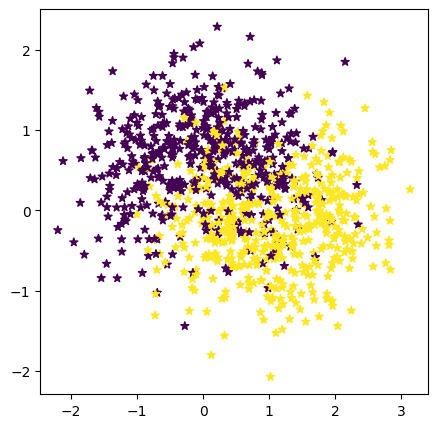

In [7]:
n_samples = 1000
X, y = make_moons(n_samples=n_samples, shuffle=True, noise=0.5)
plt.figure(figsize=(5, 5))
plt.scatter(x=X[:, 0].tolist(), y=X[:, 1].tolist(), marker='*', c=y.tolist())
plt.show()

In [11]:
num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train+num_dev], y[num_train:num_train+num_dev]
X_test, y_test = X[num_train+num_dev:], y[num_train+num_dev:]

y_train = y_train.reshape([-1,1])
y_dev = y_dev.reshape([-1,1])
y_test = y_test.reshape([-1,1])

In [12]:
print("X_train shape: ",X_train.shape, "y_train shape: ", y_train.shape)

X_train shape:  [640, 2] y_train shape:  [640, 1]


In [15]:
# 基础算子模型
class Op(object):
    def __init__(self):
        pass

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        raise NotImplementedError

    def backward(self, inputs):
        raise NotImplementedError

In [16]:
class Model_LR(Op):
    def __init__(self, input_size):
        super(Model_LR, self).__init__()
        self.params = {}
        self.params['w'] = paddle.zeros(shape=[input_size, 1])
        self.params['b'] = paddle.zeros(shape=[1])

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        score = paddle.matmul(inputs, self.params['w']) + self.params['b']
        outputs = logistic(score)
        return outputs

In [17]:
paddle.seed(0)

inputs = paddle.randn(shape=[3, 4])
print("Input is: ", inputs)
model = Model_LR(4)
outputs = model(inputs)
print("Output is: ", outputs)

Input is:  Tensor(shape=[3, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-0.92466241, -0.42534423, -2.64384580,  0.14518386],
        [-0.12086640, -0.57972574, -0.62285101, -0.32838690],
        [-1.07454193, -0.36314395, -1.67105043,  2.26550484]])
Output is:  Tensor(shape=[3, 1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.50000000],
        [0.50000000],
        [0.50000000]])


In [24]:
class BinaryCrossEntropyLoss(Op):
    def __init__(self):
        self.predicts = None
        self.labels = None 
        self.num = None 

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)

    def forward(self, predicts, labels):
        self.predicts = predicts
        self.labels = labels 
        self.num = self.predicts.shape[0]
        loss = -1. / self.num * (paddle.matmul(self.labels.t(), paddle.log(self.predicts)) + 
            paddle.matmul((1-self.labels.t()), paddle.log(1-self.predicts)))
        loss = paddle.squeeze(loss, axis=1)
        return loss 
    
labels = paddle.ones(shape=[3, 1])
bce_loss = BinaryCrossEntropyCross()
print(bce_loss(outputs, labels))


Tensor(shape=[1], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [0.69314712])


In [19]:
class Model_LR(Op):
    def __init__(self, input_size):
        super(Model_LR, self).__init__()
        self.params = {}
        self.params['w'] = paddle.zeros(shape=[input_size, 1])
        self.params['b'] = paddle.zeros(shape=[1])
        self.grads = {}
        self.X = None
        self.outputs = None 

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        self.X = inputs
        score = paddle.matmul(inputs, self.params['w']) + self.params['b']
        self.outputs = logistic(score)
        return self.outputs

    def backward(self, labels):
        N = labels.shape[0]
        self.grads['w'] = -1 / N * paddle.matmul(self.X.t(), (labels - self.outputs))
        self.grads['b'] = -1 / N * paddle.sum(labels - self.outputs)

In [20]:
from abc import abstractmethod

class Optimizer(object):
    def __init__(self, init_lr, model):
        self.init_lr = init_lr
        self.model = model 

    @abstractmethod
    def step(self):
        pass

In [21]:
class SimpleBatchGD(Optimizer):
    def __init__(self, init_lr, model):
        super(SimpleBatchGD, self).__init__(init_lr, model)

    def step(self):
        if isinstance(self.model.params, dict):
            for key in self.model.params.keys():
                self.model.params[key] = self.model.params[key] - self.init_lr * self.model.grads[key]

In [22]:
def accuracy(preds, labels):
    if preds.shape[1] == 1:
        preds = paddle.cast((preds>=0.5), dtype='float32')
    else:
        preds = paddle.argmax(preds, axis=1, dtype='int32')
    return paddle.mean(paddle.cast(paddle.equal(preds, labels), dtype='float32'))

preds = paddle.to_tensor([[0.], [1.], [1.], [0.]])
labels = paddle.to_tensor([[1.], [1.], [0.], [0.]])
print("accuracy is: ", accuracy(preds, labels))

accuracy is:  Tensor(shape=[], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       0.50000000)


In [23]:
class RunnerV2(object):
    def __init__(self, model, optimizer, metric, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn
        self.train_scores = []
        self.dev_scores = []
        self.train_loss = []
        self.dev_loss = []

    def train(self, train_set, dev_set, **kwargs):
        num_epochs = kwargs.get("num_epochs", 0)
        log_epochs = kwargs.get("log_epochs", 100)
        save_path = kwargs.get("save_path", "model_bast.pdparams")
        print_grads = kwargs.get("print_grads", None)
        best_score = 0
        for epoch in range(num_epochs):
            X, y = train_set
            logits =self.model(X)
            trn_loss = self.loss_fn(logits, y).item()
            self.train_loss.append(trn_loss)
            trn_score = self.metric(logits, y).item()
            self.train_scores.append(trn_score)
            self.model.backward(y)
            if print_grads is not None:
                print_grads(self.model) 
            self.optimizer.step()
            dev_score, dev_loss = self.evaluate(dev_set)
            if dev_score > best_score:
                self.save_model(save_path)
                print(f"best accuracy performance has been updated: {best_score:.5f} --> {dev_score:.5f}")
                best_score = dev_score
            if epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}, loss: {trn_loss}, score: {trn_score}")
                print(f"[Dev] epoch: {epoch}, loss: {dev_loss}, score: {dev_score}")
    
    def evaluate(self, data_set):
        X, y = data_set
        logits = self.model(X)
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss

    def predict(self, X):
        return self.model(X)

    def save_model(self, save_path):
        paddle.save(self.model.params, save_path)

    def load_model(self, save_path):
        self.model.params = paddle.load(save_path)

In [27]:
input_size = 2
model = Model_LR(input_size)
optimizer = SimpleBatchGD(init_lr=0.1, model=model)
loss_fn = BinaryCrossEntropyLoss()
metric = accuracy
runner = RunnerV2(model, optimizer, metric, loss_fn)
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=500, log_epochs=50, save_path="./checkpoint/model_best.pdparams")

best accuracy performance has been updated: 0.00000 --> 0.80625
[Train] epoch: 0, loss: 0.6931471228599548, score: 0.49062496423721313
[Dev] epoch: 0, loss: 0.6826697587966919, score: 0.8062500357627869
best accuracy performance has been updated: 0.80625 --> 0.80625
best accuracy performance has been updated: 0.80625 --> 0.81250
best accuracy performance has been updated: 0.81250 --> 0.81875
[Train] epoch: 50, loss: 0.5095667839050293, score: 0.7796874642372131
[Dev] epoch: 50, loss: 0.4759596288204193, score: 0.8125
[Train] epoch: 100, loss: 0.46934959292411804, score: 0.7843750715255737
[Dev] epoch: 100, loss: 0.43357202410697937, score: 0.8125
best accuracy performance has been updated: 0.81875 --> 0.82500
[Train] epoch: 150, loss: 0.45456549525260925, score: 0.7890624403953552
[Dev] epoch: 150, loss: 0.4180099070072174, score: 0.8187500238418579
[Train] epoch: 200, loss: 0.44780322909355164, score: 0.7890625
[Dev] epoch: 200, loss: 0.41045913100242615, score: 0.8250000476837158
[Tr

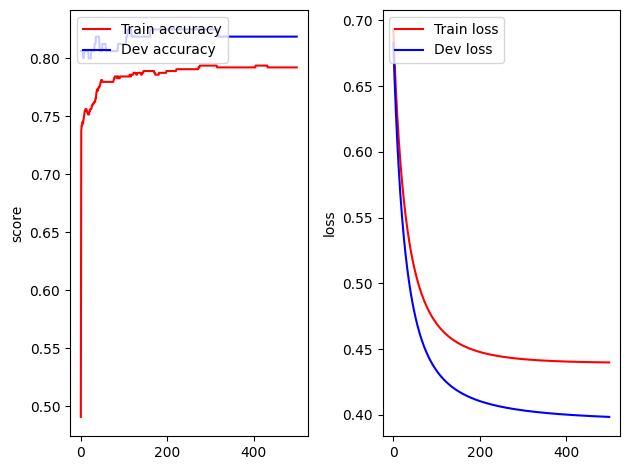

In [28]:
def plot(runner):
    plt.figure()
    plt.subplot(1,2,1)
    epochs = [i for i in range(len(runner.train_scores))]
    plt.plot(epochs, runner.train_scores, color="red", label="Train accuracy")
    plt.plot(epochs, runner.dev_scores, color="blue", label="Dev accuracy")
    plt.ylabel("score")
    plt.legend(loc="upper left")
    plt.subplot(1,2,2)
    plt.plot(epochs, runner.train_loss, color="red", label="Train loss")
    plt.plot(epochs, runner.dev_loss, color="blue", label="Dev loss")
    plt.ylabel("loss")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

plot(runner)

In [29]:
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.8300/0.3904
